<hr>  

#### About this document
_This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006) <br>This is a self contained Jupyter notebook with structure introduction, discussion and embeded code and bibliography._
<br>

**Code is hosted [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/cw_casa06.ipynb)**<br>

**Data is availble [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/tree/master/data)**<br>

<hr>

# Analysis and prediction of regional demand for taxis based on spatiotemporal sequence data: 
_the case of the New York City_  

This paper explores trip record data from the TLC in New York City, and based on the city's provided geographic boundaries, obtains temporal characteristics of demand relationships at the district level.  
It emphasizes the analysis of the changes in cab demand in each region over time to ultimately obtain a model that can predict changes in demand.


<hr>

# Guide
- [Passenger Behavior Patterns Based on Spatio-Temporal Sequences of Taxi Trajectory Data:](#passenger-behavior-patterns-based-on-spatio-temporal-sequences-of-taxi-trajectory-data-)
  * [1 Introduction](#1-introduction)
    + [1.1 Background](#11-background)
    + [1.2 Research question](#12-research-question)
    + [1.3 Requirements to run the analysis](#13-requirements-to-run-the-analysis)
  * [2 Literature Review](#2-literature-review)
  * [3 Presentation of data](#3-presentation-of-data)
  * [4 Methodology](#4-methodology)
  * [5 Analysis](#5-analysis)
  * [6 Results](#6-results)
  * [7 Discussion](#7-discussion)
  * [8 Conclusion](#8-conclusion)
  * [Bibliography](#bibliography)
  * [Appendix](#appendix)


## 1 Introduction

### 1.1 Background  

需要改————  
Taxis are an important means of transportation in urban areas, and accurately predicting taxi demand is essential for optimizing urban traffic and planning travel routes. In this study, we used trip data from taxis in New York City and applied spatial and temporal analysis methods to analyze and predict taxi demand in different regions of the city. By comparing three commonly used prediction algorithms, we identified the best model and used it to predict the trend of taxi demand for the next year. The results of this study can help optimize urban transportation planning and travel services, and improve the efficiency and convenience of urban travel.


### 1.2 Research question  
The aim of this research is to analyze the spatiotemporal characteristics of taxi demand in different regions based on the time series data of New York City's taxi trips, and use machine learning algorithms to make predictions, in order to provide decision support for urban transportation planning and taxi service optimization. Specifically, our research question is: How to analyze the spatiotemporal characteristics of taxi demand in different regions based on the time series data of New York City's taxi trips, and use machine learning algorithms to predict the future changes in taxi demand in each region?

### 1.3 Requirements to run the analysis

An overview of packages used to run the analysis with brief explanation of their role.

In [42]:
import geopandas as gpd 
import matplotlib.pyplot as plt 

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

import os
import pandas as pd
from tqdm import tqdm

import numpy as np
import glob
from fastparquet import ParquetFile

<hr>

## 2 Literature Review  

<hr>

## 3 Presentation of data 

### 3.1 Research area

研究区域为TLC Taxi Zone范围。TLC Taxi Zone是由TLC自主定义的区域边界，将纽约市分为了6个大区和263个小区域。 每个小区域都有唯一编号。Taxi zone lookup table is [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/data/taxi_zone_lookup.csv)

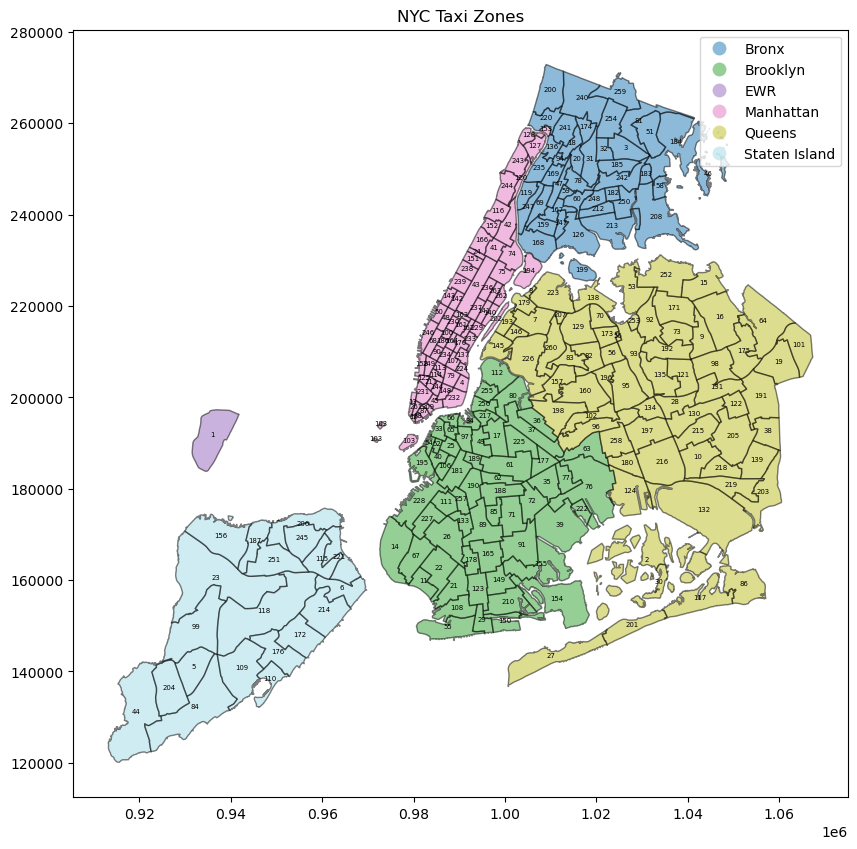

In [ ]:
# Read shapefile
shp_file = 'data/taxi_zones/taxi_zones.shp'
map_df = gpd.read_file(shp_file)

# Create a new figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot the GeoDataFrame and color the polygons based on the 'borough' column
map_df.plot(ax=ax, column='borough', cmap='tab20', alpha=0.5, edgecolor='k', legend=True)

# Add labels to each polygon
for idx, row in map_df.iterrows():
    ax.annotate(row['LocationID'], row['geometry'].centroid.coords[0], fontsize=5,horizontalalignment='center')

# Set the title of the plot
ax.set_title('NYC Taxi Zones')

# Show the plot
plt.show()

### 3.2 Data discription

New York City Taxi and Limousine Commission(TLC)是负责许可和监管纽约市的出租车、通勤车和残疾人运输车辆的机构。该组织在其官方网站上公开了TLC Trip Record Data。TLC Trip Record Data包含了出租车的pick-up and drop-off dates/times, pick-up and drop-off locations等信息。   
本文将主要使用自2019年2月至2023年1月来每个月的For-Hire Vehicle (“FHV”) trip records来对出租车的空间需求特征进行分析和预测。

本文将使用的FHV Trip Records的字段如下：
|Field Name|Description|
|--|--|
|Pickup_datetime|The date and time of the trip pick-up|
|DropOff_datetime|The date and time of the trip dropoff|
|PULocationID|TLC Taxi Zone in which the trip began|
|DOLocationID|TLC Taxi Zone in which the trip ended|

FHV Trip Records的详细数据字典 is [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/data/FHV_data/data_dictionary_trip_records_fhv.pdf)

### 3.3 Exploratory Data Analysis

#### 3.3.1 总体性需求的变化情况

需求数量的总变化情况，将单次行程的始发时间作为统计量

In [106]:
# 设置FHV数据目录的路径
fhv_data_dir = "data/FHV_data"

# 初始化空的time_list dataframe
time_list = pd.DataFrame(None, columns=["time", "count"])

In [107]:
# 遍历FHV_data文件夹下所有年份下的parquet文件
for year_dir in tqdm(os.listdir(fhv_data_dir), desc="Reading File:"):
    year_path = os.path.join(fhv_data_dir, year_dir)
    if os.path.isdir(year_path) and year_dir.isdigit() and int(year_dir) >= 2019:
        for file_name in tqdm(os.listdir(year_path), desc="Calcualting:"):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(year_path, file_name)
                # print('read:'+ file_path)
                # 读取parquet文件并转换为pandas dataframe
                table = pq.read_table(file_path)
                df = table.to_pandas(safe=False)
                
                # 验证pickup_datetime是否在文件所在文件夹名所表示的年份范围内
                pickup_dates = pd.to_datetime(df["pickup_datetime"])
                mask = (pickup_dates.dt.year == int(year_dir))
                df = df[mask]
                
                # 统计每一天的订单数量，并将结果追加到time_list中
                counts = df["pickup_datetime"].dt.date.value_counts().sort_index()
                dates = counts.index
                
                time_list = pd.concat([time_list, pd.DataFrame({"time": dates, "count": counts.values})], ignore_index=True)
                
                # 释放在以上步骤中创建的，除了time_list以外的所有变量值
                # del table, df, pickup_dates, mask, counts, dates

# 将time_list按照日期排序并设置日期为索引
# time_list = time_list.sort_values("time").set_index("time")
time_list = time_list.dropna(subset=['time'])
time_list = time_list.sort_values("time")
# time_list

Reading File:: 100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


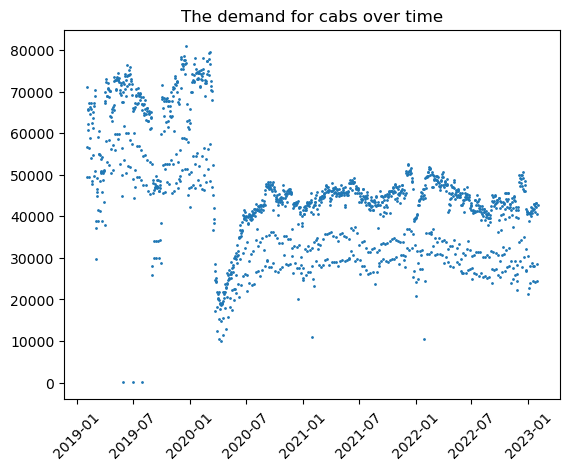

In [111]:
# 可视化
plt.scatter(time_list['time'], time_list['count'], s=1)
plt.title("The demand for cabs over time")
plt.xticks(rotation=45)
plt.show()

需求数量的年度变化情况

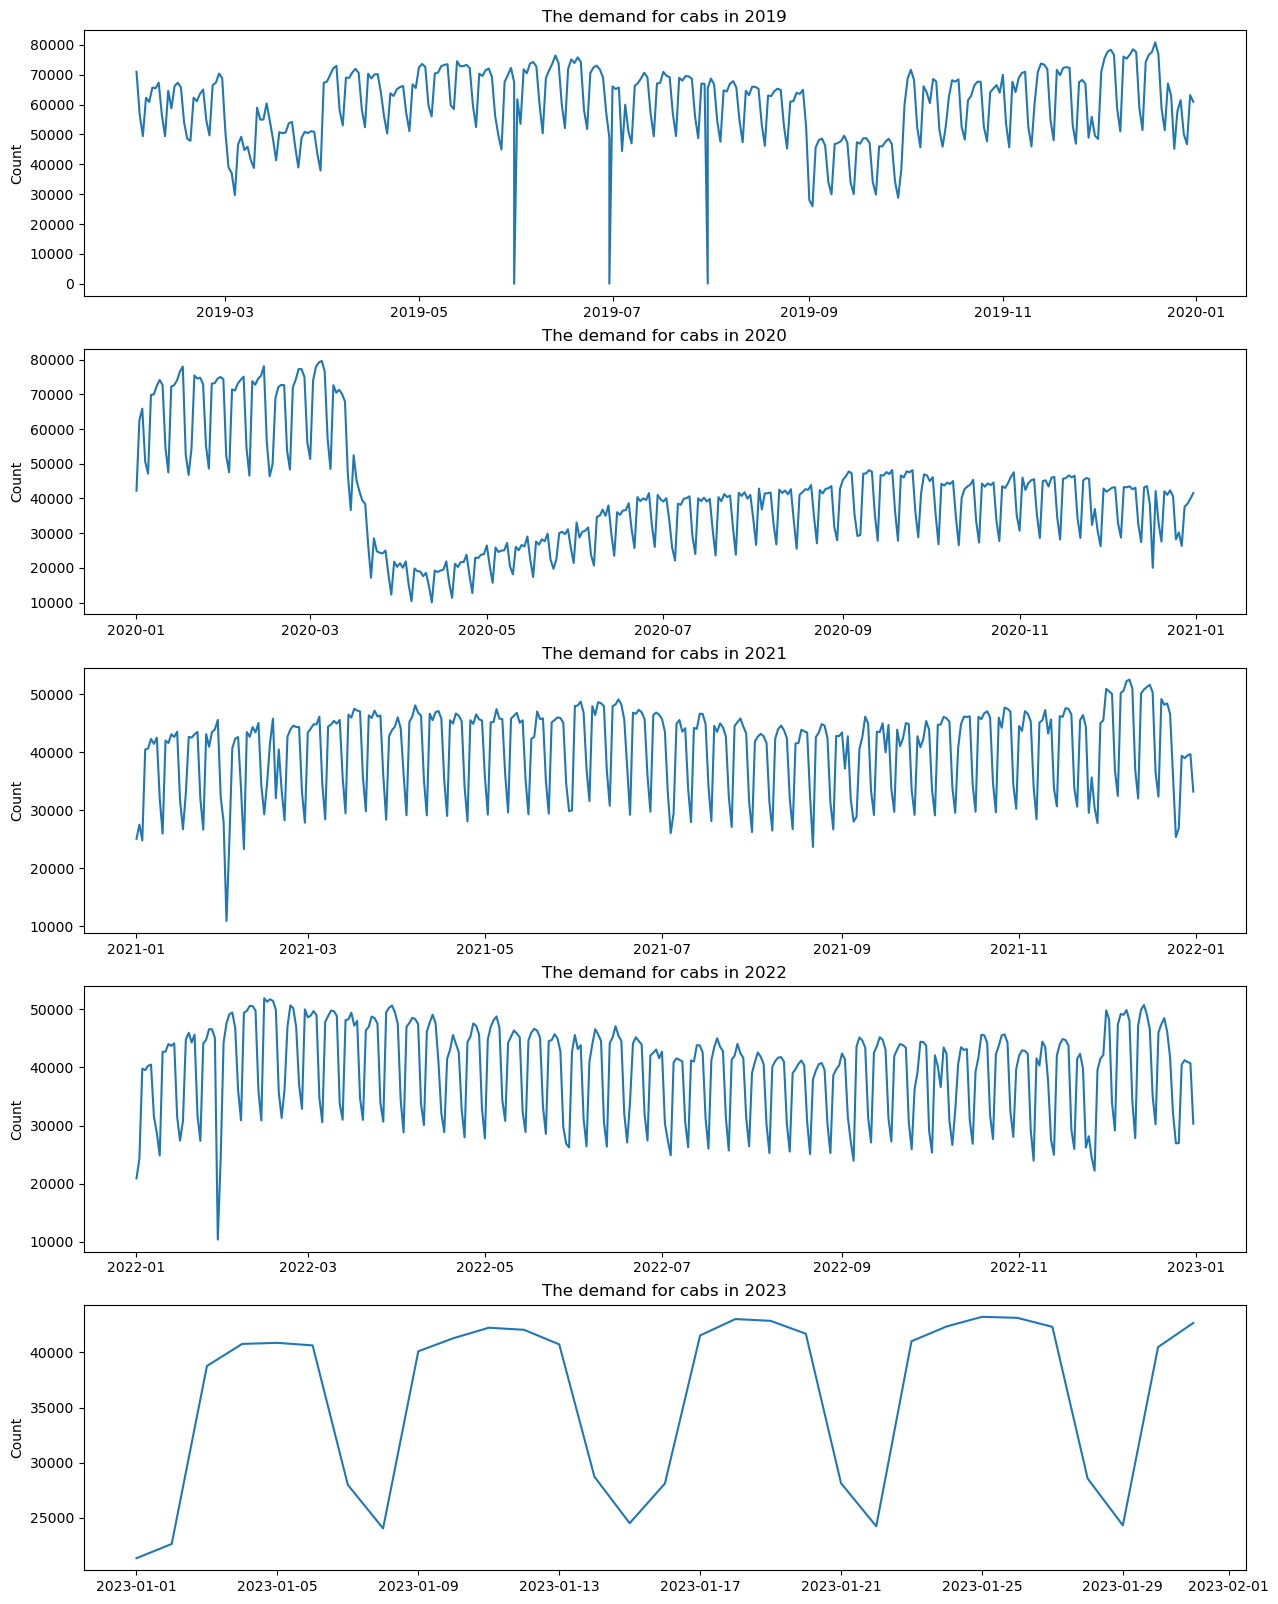

In [122]:
df = time_list
df['time'] = pd.to_datetime(df['time'])

# 按年份分组
df_grouped = df.groupby(df['time'].dt.year)

# plot
fig, axs = plt.subplots(5, 1, figsize=(15, 20))
for i, (year, group) in enumerate(df_grouped):
    axs[i].plot(group['time'], group['count'])
    axs[i].set_title('The demand for cabs in ' + str(year))
    # axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Count')

plt.show()

#### 3.3.2 区域性需求变化情况

六个大区的需求数据统计，直接按大区展示

In [127]:
# 初始化值，并创建time_list_pickup存储最终数据
# 设置FHV数据目录的路径
fhv_data_dir = "data/FHV_data"

# 初始化空的time_list_pickup dataframe
time_list_pickup = pd.DataFrame(None, columns=["time","location", "count"])


In [ ]:
# 读取数据，存储到time_list_pickup中
# 遍历FHV_data文件夹下所有年份下的parquet文件
for year_dir in tqdm(os.listdir(fhv_data_dir), desc="Reading File:"):
    year_path = os.path.join(fhv_data_dir, year_dir)
    if os.path.isdir(year_path) and year_dir.isdigit() and int(year_dir) >= 2019:
        for file_name in tqdm(os.listdir(year_path), desc="Calcualting:"):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(year_path, file_name)
                # print('read:'+ file_path)
                # 读取parquet文件并转换为pandas dataframe
                table = pq.read_table(file_path)
                df = table.to_pandas(safe=False)

                
                
                # 验证pickup_datetime是否在文件所在文件夹名所表示的年份范围内
                pickup_dates = pd.to_datetime(df["pickup_datetime"])
                mask = (pickup_dates.dt.year == int(year_dir))
                df = df[mask]
                
                # 统计每一天的订单数量，并将结果追加到time_list中
                counts = df["pickup_datetime"].dt.date.value_counts().sort_index()
                dates = counts.index
                
                time_list = pd.concat([time_list, pd.DataFrame({"time": dates, "count": counts.values})], ignore_index=True)
                
                # 释放在以上步骤中创建的，除了time_list以外的所有变量值
                # del table, df, pickup_dates, mask, counts, dates

# 将time_list按照日期排序并设置日期为索引
# time_list = time_list.sort_values("time").set_index("time")
time_list = time_list.dropna(subset=['time'])
time_list = time_list.sort_values("time")
# time_list

In [145]:
categories_list = []
for i in range(265):
    categories_list.append(str(i+1))
# categories

In [147]:
table = pq.read_table('data/FHV_data/2019/fhv_tripdata_2019-02.parquet')
df = table.to_pandas(safe=False)
df = df[['pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID']]
df['PUlocationID'] = df['PUlocationID'].astype('category')
df['PUlocationID'] = df['PUlocationID'].astype('category')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707650 entries, 0 to 1707649
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pickup_datetime   datetime64[ns]
 1   dropOff_datetime  datetime64[ns]
 2   PUlocationID      category      
 3   DOlocationID      float64       
dtypes: category(1), datetime64[ns](2), float64(1)
memory usage: 42.4 MB


,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
0,2019-02-01 00:08:44,2019-02-01 00:23:35,264.0,265.0
1,2019-02-01 00:27:51,2019-02-01 00:32:54,264.0,265.0
2,2019-02-01 00:18:30,2019-02-01 00:25:45,264.0,265.0
3,2019-02-01 00:43:15,2019-02-01 00:48:29,264.0,265.0
4,2019-02-01 00:01:45,2019-02-01 00:09:13,264.0,265.0


In [154]:
df_pu = df[['pickup_datetime', 'PUlocationID']]
df_do = df[['dropOff_datetime', 'DOlocationID']]

In [155]:
df_pu = pd.get_dummies(df_pu, drop_first=True, dummy_na=True, dtype=int)
df_pu.info()
df_pu.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707650 entries, 0 to 1707649
Columns: 261 entries, pickup_datetime to PUlocationID_nan
dtypes: datetime64[ns](1), int32(260)
memory usage: 1.7 GB


,pickup_datetime,PUlocationID_3.0,PUlocationID_4.0,PUlocationID_5.0,PUlocationID_6.0,PUlocationID_7.0,PUlocationID_8.0,PUlocationID_9.0,PUlocationID_10.0,PUlocationID_11.0,...,PUlocationID_257.0,PUlocationID_258.0,PUlocationID_259.0,PUlocationID_260.0,PUlocationID_261.0,PUlocationID_262.0,PUlocationID_263.0,PUlocationID_264.0,PUlocationID_265.0,PUlocationID_nan
0,2019-02-01 00:08:44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2019-02-01 00:27:51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2019-02-01 00:18:30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2019-02-01 00:43:15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-02-01 00:01:45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<hr>

## 4 Methodology 

<hr>

## 5 Analysis

从原始数据的角度出发，20年的出租车使用量有大幅度的下降。若不考虑数据采集本身造成的系统误差的情况下，造成这种结果的主要原因应该为新冠疫情的爆发。
2020年3月1日，第一个COVID-19病例被证实，到3月29日，超过30,000个病例被证实。 为了应对疫情，纽约州州长办公室于3月20日发布行政命令，关闭 "非必要 "企业。封锁将病毒热点根据其严重程度在地图上划分为红色、橙色和黄色区域。封锁还对宗教场所和餐馆进行了严格限制。timeline：https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

经过几个月的恢复，出租车的使用量逐渐回升



<hr>

## 6 Results

<hr>

## 7 Discussion

<hr>

## 8 Conclusion

<hr>

## Bibliography

<hr>

## Appendix

**Data Source**:   
TLC Trip Record Data - TLC: [https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

碎碎念

我打算基于TLC的数据，对数据进行简单的EDA；然后对同一数据集（2020，2021和2022年的数据为训练集，2023年作为检验集）使用三种算法（分别为CART，ARIMA，LSTM或者Prophet中的一个）来进行预测，最终对模型结果进行一个比较和评估。